In [1]:
import numpy as np

# Load dataset files
synthetic_eeg_eog_path = "/home/tulgaa/Desktop/emg_dataset/signal/Linear_synthetic_eeg_emg.npy"
clean_eeg_path = "/home/tulgaa/Desktop/emg_dataset/signal/EEG_all_epochs.npy"

# Load the numpy arrays
synthetic_eeg_eog = np.load(synthetic_eeg_eog_path, allow_pickle=True).item()  # Dictionary of SNR levels
clean_eeg = np.load(clean_eeg_path)  # Ground truth EEG

# Inspect dataset keys and shapes
print("🔹 Synthetic EEG+EOG Dictionary Keys (SNR Levels):", synthetic_eeg_eog.keys())
print("🔹 Clean EEG Shape:", clean_eeg.shape)

# Print shape of each SNR level data
for snr in synthetic_eeg_eog.keys():
    print(f"🔹 SNR Level {snr}: Shape = {synthetic_eeg_eog[snr].shape}")

# Check statistics of clean EEG data
print("🔹 Clean EEG Mean:", np.mean(clean_eeg))
print("🔹 Clean EEG Std Dev:", np.std(clean_eeg))

🔹 Synthetic EEG+EOG Dictionary Keys (SNR Levels): dict_keys([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])
🔹 Clean EEG Shape: (4514, 1024)
🔹 SNR Level -7: Shape = (4514, 1024)
🔹 SNR Level -6: Shape = (4514, 1024)
🔹 SNR Level -5: Shape = (4514, 1024)
🔹 SNR Level -4: Shape = (4514, 1024)
🔹 SNR Level -3: Shape = (4514, 1024)
🔹 SNR Level -2: Shape = (4514, 1024)
🔹 SNR Level -1: Shape = (4514, 1024)
🔹 SNR Level 0: Shape = (4514, 1024)
🔹 SNR Level 1: Shape = (4514, 1024)
🔹 SNR Level 2: Shape = (4514, 1024)
🔹 Clean EEG Mean: -0.01437441971536275
🔹 Clean EEG Std Dev: 228.54837530823107


In [2]:
import torch
from sklearn.model_selection import train_test_split

# Lists to store train/test data
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# Loop through each SNR level
for snr in synthetic_eeg_eog.keys():
    contaminated_signals = synthetic_eeg_eog[snr]  # Shape: (3400, 512)
    clean_signals = clean_eeg  # Shape: (3400, 512) (Assuming same order for each SNR)

    # Split 80% training, 20% testing
    X_train, X_test, y_train, y_test = train_test_split(
        contaminated_signals, clean_signals, test_size=0.2, random_state=42
    )

    # Append to respective lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

# Stack training and testing data
X_train_final = np.vstack(X_train_list)
X_test_final = np.vstack(X_test_list)
y_train_final = np.vstack(y_train_list)
y_test_final = np.vstack(y_test_list)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_final, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_final, dtype=torch.float32)

# Print final dataset shapes
print("✅ Training Set Shape:", X_train_tensor.shape, "Target Shape:", y_train_tensor.shape)
print("✅ Testing Set Shape:", X_test_tensor.shape, "Target Shape:", y_test_tensor.shape)

✅ Training Set Shape: torch.Size([36110, 1024]) Target Shape: torch.Size([36110, 1024])
✅ Testing Set Shape: torch.Size([9030, 1024]) Target Shape: torch.Size([9030, 1024])


In [3]:
import torch
import torch.nn as nn
class SimpleCNN(nn.Module):
    def __init__(self, input_length):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(1024 * 64, 1024)

    def forward(self, x):
        #x = x.unsqueeze(1)  # Add channel dimension (batch, 1, input_length)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Initialize the model with input_length=512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(input_length=1024).to(device)
print(model)

# ... (rest of your training/evaluation code)

SimpleCNN(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=65536, out_features=1024, bias=True)
)


In [4]:
import torch.optim as optim

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {device}")

# Move model to GPU (✅ Pass input_length!)
model = SimpleCNN(input_length=512).to(device)

# Define loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Early Stopping Parameters
patience = 5  # Stop if validation loss does not improve for 10 epochs
best_val_loss = float('inf')
epochs_no_improve = 0


🔥 Using device: cuda


In [6]:
import time

def train_model(model, X_train, y_train, X_test, y_test, epochs=1000, batch_size=64):
    global best_val_loss, epochs_no_improve
    model.train()
    
    # Move tensors to GPU
    X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # Create Data Loaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

    for epoch in range(epochs):
        start_time = time.time()
        train_loss = 0.0

        # Training loop
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to GPU
            optimizer.zero_grad()
            output = model(X_batch.unsqueeze(1))
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Compute average training loss
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation loss calculation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)  # Move data to GPU
                val_output = model(X_val.unsqueeze(1))
                val_loss += criterion(val_output, y_val).item()
        
        avg_val_loss = val_loss / len(test_loader)
        elapsed_time = time.time() - start_time

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f} - Time: {elapsed_time:.2f}s")

        # Early Stopping Logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_eegdnet.pth")  # Save the best model
            print("✅ Model improved! Saving checkpoint.")
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered!")
            break

        model.train()  # Switch back to training mode

# Start Training with CUDA
train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=50, batch_size=256)

Epoch [1/50] - Train Loss: 23901.257634 - Val Loss: 25635.656359 - Time: 3.76s
✅ Model improved! Saving checkpoint.
Epoch [2/50] - Train Loss: 22755.687789 - Val Loss: 24821.773438 - Time: 3.74s
✅ Model improved! Saving checkpoint.
Epoch [3/50] - Train Loss: 21785.248102 - Val Loss: 23972.457031 - Time: 3.69s
✅ Model improved! Saving checkpoint.
Epoch [4/50] - Train Loss: 20986.690911 - Val Loss: 22931.935981 - Time: 3.74s
✅ Model improved! Saving checkpoint.
Epoch [5/50] - Train Loss: 20201.522942 - Val Loss: 22347.763455 - Time: 3.70s
✅ Model improved! Saving checkpoint.
Epoch [6/50] - Train Loss: 19515.688160 - Val Loss: 21668.998047 - Time: 3.79s
✅ Model improved! Saving checkpoint.
Epoch [7/50] - Train Loss: 18864.996871 - Val Loss: 21193.529188 - Time: 3.68s
✅ Model improved! Saving checkpoint.
Epoch [8/50] - Train Loss: 18298.759938 - Val Loss: 20779.536675 - Time: 3.67s
✅ Model improved! Saving checkpoint.
Epoch [9/50] - Train Loss: 17742.577052 - Val Loss: 20209.848958 - Time:

In [7]:
print(f"X_train shape: {X_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}")
print(f"y_test shape: {y_test_tensor.shape}")


X_train shape: torch.Size([36110, 1024])
y_train shape: torch.Size([36110, 1024])
X_test shape: torch.Size([9030, 1024])
y_test shape: torch.Size([9030, 1024])


In [8]:
import torch
import numpy as np
from scipy.signal import welch
import torch.nn.functional as F

def compute_rrmse_t(gt, pred):
    """
    Compute Temporal RRMSE (Lower is better).
    Formula: RRMSE_T = ||pred - gt||_2 / ||gt||_2
    """
    return torch.norm(pred - gt, p=2) / torch.norm(gt, p=2)

def compute_rrmse_s(gt, pred, fs=512):
    """
    Compute Spectral RRMSE (Lower is better).
    Formula: RRMSE_S = ||PSD(pred) - PSD(gt)||_2 / ||PSD(gt)||_2
    """
    def compute_psd(signal):
        f, psd = welch(signal, fs=fs, nperseg=256)  # Power Spectral Density
        return torch.tensor(psd, dtype=torch.float32)

    psd_gt = compute_psd(gt.cpu().numpy())
    psd_pred = compute_psd(pred.cpu().numpy())

    return torch.norm(psd_pred - psd_gt, p=2) / torch.norm(psd_gt, p=2)

def compute_cc(gt, pred):
    """
    Compute Correlation Coefficient (Higher is better).
    Formula: CC = Cov(gt, pred) / (std(gt) * std(pred))
    """
    gt_mean, pred_mean = torch.mean(gt), torch.mean(pred)
    numerator = torch.sum((gt - gt_mean) * (pred - pred_mean))
    denominator = torch.sqrt(torch.sum((gt - gt_mean) ** 2) * torch.sum((pred - pred_mean) ** 2))

    return numerator / (denominator + 1e-8)  # Avoid division by zero

In [9]:
def evaluate_per_snr(model, X_test_final, y_test_final):
    """
    Evaluate model performance per SNR level using pre-split test data.
    """
    model.eval()  # Set model to evaluation mode
    
    snr_metrics = {}

    with torch.no_grad():
        # Move test data to GPU
        X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test_final, dtype=torch.float32).to(device)

        # Get model predictions
        y_pred_tensor = model(X_test_tensor)

        # Compute metrics
        rrmse_t = compute_rrmse_t(y_test_tensor, y_pred_tensor).cpu().item()
        rrmse_s = compute_rrmse_s(y_test_tensor, y_pred_tensor).cpu().item()
        cc = compute_cc(y_test_tensor, y_pred_tensor).cpu().item()

        # Store results
        snr_metrics["Overall"] = {
            "RRMSE_T": rrmse_t,
            "RRMSE_S": rrmse_s,
            "CC": cc
        }

        print(f"✅ Overall Test Set Evaluation: RRMSE_T = {rrmse_t:.4f}, RRMSE_S = {rrmse_s:.4f}, CC = {cc:.4f}")

    return snr_metrics

In [10]:

def compute_average_metrics(snr_metrics):
    """
    Compute the final average performance of RRMSE_T, RRMSE_S, and CC across all SNRs.
    """
    avg_rrmse_t = sum([snr_metrics[snr]["RRMSE_T"] for snr in snr_metrics]) / len(snr_metrics)
    avg_rrmse_s = sum([snr_metrics[snr]["RRMSE_S"] for snr in snr_metrics]) / len(snr_metrics)
    avg_cc = sum([snr_metrics[snr]["CC"] for snr in snr_metrics]) / len(snr_metrics)
    
    print("\n🔹 **Final Average Results Across All SNRs** 🔹")
    print(f"✅ Average RRMSE_T: {avg_rrmse_t:.4f} (Lower is better)")
    print(f"✅ Average RRMSE_S: {avg_rrmse_s:.4f} (Lower is better)")
    print(f"✅ Average CC: {avg_cc:.4f} (Higher is better)")

    return avg_rrmse_t, avg_rrmse_s, avg_cc

In [11]:
import torch
import numpy as np
from scipy.stats import pearsonr
from scipy.fftpack import fft

# Function to compute RRMSE
def compute_rrmse(denoised, clean):
    return np.sqrt(np.mean((denoised - clean) ** 2)) / np.sqrt(np.mean(clean ** 2))

# Function to compute RRMSE in the Spectrum Domain
def compute_rrmse_spectrum(denoised, clean):
    fft_clean = np.abs(fft(clean))  # Compute FFT
    fft_denoised = np.abs(fft(denoised))
    return compute_rrmse(fft_denoised, fft_clean)

# Function to compute Correlation Coefficient (CC)
def compute_cc(denoised, clean):
    try:
        return pearsonr(denoised.flatten(), clean.flatten())[0]
    except:
        return 0  # Handle errors gracefully

# Store results
snr_metrics = {}

# Lists to store metrics for computing overall averages
all_rrmse_t = []
all_rrmse_s = []
all_cc = []

# Loop through each SNR level using pre-split test data
with torch.no_grad():
    for snr_idx, snr in enumerate(sorted(synthetic_eeg_eog.keys())):
        print(f"🔹 Evaluating SNR Level: {snr}")

        # Get test data from pre-split dataset
        X_test_snr = X_test_list[snr_idx]  # Noisy EEG from test set
        y_test_snr = y_test_list[snr_idx]  # Clean EEG from test set

        # Convert to PyTorch tensors and reshape for LSTMX_test_tensor = torch.tensor(X_test_snr, dtype=torch.float32).unsqueeze(1).to(device)   # ✅ (680, 1, 512)
        X_test_tensor = torch.tensor(X_test_snr, dtype=torch.float32).unsqueeze(1).to(device)  # (batch, 512, 1)
        y_test_tensor = torch.tensor(y_test_snr, dtype=torch.float32).to(device)  # (680, 512)


        # Get model predictions
        y_pred_tensor = model(X_test_tensor).cpu().detach().numpy()
        y_pred_tensor = y_pred_tensor.reshape(y_test_snr.shape)  # Ensure correct shape

        # Compute metrics
        rrmse_t_list = [compute_rrmse(y_pred_tensor[i], y_test_snr[i]) for i in range(len(y_test_snr))]
        rrmse_s_list = [compute_rrmse_spectrum(y_pred_tensor[i], y_test_snr[i]) for i in range(len(y_test_snr))]
        cc_list = [compute_cc(y_pred_tensor[i], y_test_snr[i]) for i in range(len(y_test_snr))]

        # Store results for this SNR level
        snr_metrics[snr] = {
            "RRMSE-T": np.mean(rrmse_t_list),
            "RRMSE-S": np.mean(rrmse_s_list),
            "CC": np.mean(cc_list)
        }

        # Append values for overall averages
        all_rrmse_t.extend(rrmse_t_list)
        all_rrmse_s.extend(rrmse_s_list)
        all_cc.extend(cc_list)

# Compute Overall Averages
overall_rrmse_t = np.mean(all_rrmse_t)
overall_rrmse_s = np.mean(all_rrmse_s)
overall_cc = np.mean(all_cc)

# Print Results in Table Format
print("\n🔹 **Final Evaluation Per SNR Level:**")
print("-----------------------------------------------------")
print("| SNR  |  RRMSE-T  |  RRMSE-S  |   CC   |")
print("-----------------------------------------------------")
for snr in sorted(snr_metrics.keys()):
    print(f"| {snr:3d}  |  {snr_metrics[snr]['RRMSE-T']:.6f}  |  {snr_metrics[snr]['RRMSE-S']:.6f}  |  {snr_metrics[snr]['CC']:.6f}  |")
print("-----------------------------------------------------")

# Print Overall Averages
print("\n🔹 **Overall Averages:**")
print(f"✅ RRMSE-T (Time Domain): {overall_rrmse_t:.6f}")
print(f"✅ RRMSE-S (Spectrum Domain): {overall_rrmse_s:.6f}")
print(f"✅ Correlation Coefficient (CC): {overall_cc:.6f}")

🔹 Evaluating SNR Level: -7
🔹 Evaluating SNR Level: -6
🔹 Evaluating SNR Level: -5
🔹 Evaluating SNR Level: -4
🔹 Evaluating SNR Level: -3
🔹 Evaluating SNR Level: -2
🔹 Evaluating SNR Level: -1
🔹 Evaluating SNR Level: 0
🔹 Evaluating SNR Level: 1
🔹 Evaluating SNR Level: 2

🔹 **Final Evaluation Per SNR Level:**
-----------------------------------------------------
| SNR  |  RRMSE-T  |  RRMSE-S  |   CC   |
-----------------------------------------------------
|  -7  |  0.640117  |  0.450568  |  0.767659  |
|  -6  |  0.607565  |  0.427318  |  0.792435  |
|  -5  |  0.576708  |  0.405293  |  0.814118  |
|  -4  |  0.548056  |  0.384927  |  0.832843  |
|  -3  |  0.521988  |  0.366560  |  0.848815  |
|  -2  |  0.498811  |  0.350370  |  0.862264  |
|  -1  |  0.478634  |  0.336453  |  0.873476  |
|   0  |  0.461433  |  0.324768  |  0.882732  |
|   1  |  0.447076  |  0.315275  |  0.890314  |
|   2  |  0.435330  |  0.307787  |  0.896482  |
-----------------------------------------------------

🔹 **Overa

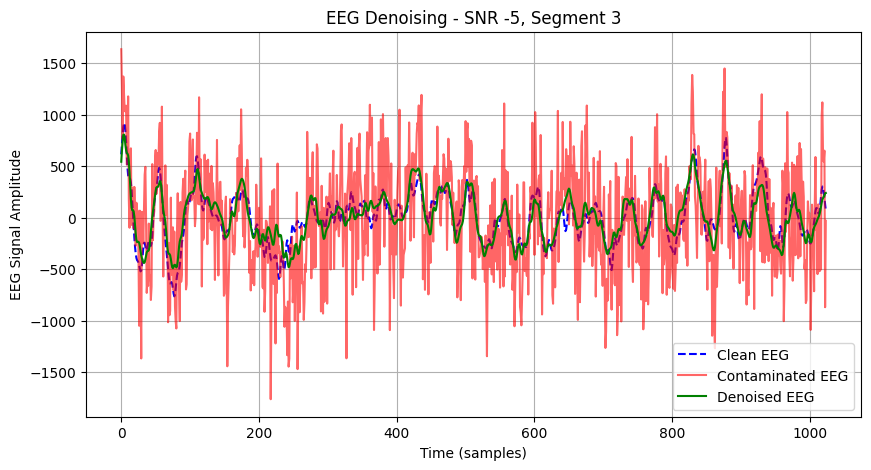

In [19]:
import matplotlib.pyplot as plt

# Select SNR=1 and 0th segment
snr_level = -5
snr_idx = list(sorted(synthetic_eeg_eog.keys())).index(snr_level)  # Find the index of SNR=1

# Get test data
noisy_snr = X_test_list[snr_idx]  # Noisy (contaminated) EEG from test set
clean_snr = y_test_list[snr_idx]  # Clean EEG from test set

# Convert to PyTorch tensor and denoise
noisy_tensor = torch.tensor(noisy_snr, dtype=torch.float32).unsqueeze(1).to(device)  # (batch, 512, 1)
denoised_tensor = model(noisy_tensor).cpu().detach().numpy()
denoised_tensor = denoised_tensor.reshape(clean_snr.shape)  # Ensure correct shape

# Select the 0th segment (first sample)
segment_idx = 3
noisy_segment = noisy_snr[segment_idx]
clean_segment = clean_snr[segment_idx]
denoised_segment = denoised_tensor[segment_idx]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(clean_segment, label="Clean EEG", color="blue", linestyle="dashed", linewidth=1.5)
plt.plot(noisy_segment, label="Contaminated EEG", color="red", alpha=0.6)
plt.plot(denoised_segment, label="Denoised EEG", color="green", linewidth=1.5)

plt.xlabel("Time (samples)")
plt.ylabel("EEG Signal Amplitude")
plt.title(f"EEG Denoising - SNR {snr_level}, Segment {segment_idx}")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Get x and y values of the denoised EEG segment
x_points = list(range(len(denoised_segment)))  # X-axis: time/sample index
y_points = denoised_segment.tolist()           # Y-axis: denoised signal values

# Print the plotting points
print("Denoised EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")


Denoised EEG Plotting Points:
(0, 543.6907958984375)
(1, 652.9649658203125)
(2, 741.2740478515625)
(3, 805.413330078125)
(4, 807.681884765625)
(5, 773.2216796875)
(6, 707.99462890625)
(7, 657.5269775390625)
(8, 628.8549194335938)
(9, 622.7125244140625)
(10, 605.0975952148438)
(11, 547.9136352539062)
(12, 442.229248046875)
(13, 307.3475036621094)
(14, 178.85037231445312)
(15, 97.65555572509766)
(16, 71.90299987792969)
(17, 72.82633209228516)
(18, 61.52546691894531)
(19, 11.692720413208008)
(20, -69.65744018554688)
(21, -155.80474853515625)
(22, -213.91326904296875)
(23, -236.59539794921875)
(24, -236.32806396484375)
(25, -233.40048217773438)
(26, -243.72271728515625)
(27, -277.5315856933594)
(28, -323.0538635253906)
(29, -364.13372802734375)
(30, -393.623291015625)
(31, -416.16961669921875)
(32, -432.60638427734375)
(33, -440.41650390625)
(34, -432.0780944824219)
(35, -405.57965087890625)
(36, -368.45062255859375)
(37, -336.2733459472656)
(38, -323.11456298828125)
(39, -322.594177246093

In [21]:

# Get x and y values of the denoised EEG segment
x_points = list(range(len(noisy_segment)))  # X-axis: time/sample index
y_points = noisy_segment.tolist()           # Y-axis: denoised signal values

# Print the plotting points
print("Contaminated EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")


Contaminated EEG Plotting Points:
(0, 1636.3954075441677)
(1, 1255.705710942903)
(2, 763.145162023332)
(3, 1371.691123827098)
(4, 1214.4375270007038)
(5, 1036.54271380131)
(6, 1031.912178953688)
(7, 1088.3846059231291)
(8, 516.848323608457)
(9, 528.9623420523876)
(10, 1178.4521274208262)
(11, 180.10566414242564)
(12, -97.38291391773788)
(13, 483.78683678064976)
(14, 673.8637052592408)
(15, -69.82294944135248)
(16, 88.3026446643791)
(17, 291.83078528666954)
(18, -105.21915481041279)
(19, 298.98970540020775)
(20, 70.6210328678859)
(21, -272.3925714738966)
(22, 145.4081048919499)
(23, 71.37474190142154)
(24, 65.8712557834454)
(25, -339.3791782523666)
(26, -1049.3984661047689)
(27, 68.32677790660244)
(28, -593.2579383023461)
(29, -1366.8546990984973)
(30, 57.506749550279835)
(31, 1.6197674692491546)
(32, -248.10737885335286)
(33, 105.50555160344575)
(34, 417.6348198869139)
(35, 494.13622765277864)
(36, -10.535532065295001)
(37, -730.1108498466101)
(38, -599.3775831919436)
(39, -661.5515187